### Code to segment the image with a window size 512 X 512, count the number of pixels with labels and create a target variable

In [37]:
# Importing the packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from skimage import io, filters, color
from skimage.transform import rescale, resize, downscale_local_mean
from scipy import ndimage
import sys
from sklearn.model_selection import train_test_split
from pathlib import Path
import splitfolders

In [2]:
# Reading the image without labels

img = cv2.imread('m05.png')

# Reading the image with labels

img_label = cv2.imread('m05-label.png')

In [3]:
# saving the image with labels to a temp variable 

tmp=img_label

In [4]:
# Definig the image window size and step size

stepsize=512
(w_width, w_height) = (512, 512)

In [5]:
# array to store the image segments

img_array= []
img_label_array = []

# array to store pixel information

pixel_loc = []

for x in range(0, img.shape[1] - w_width, stepsize):
    for y in range(0, img.shape[0] - w_height, stepsize):
        pix_loc = x, y#x+w_width, y+w_height
        window = img[y:y+w_height, x:x+w_width, :]
        window_label = img_label[ y:y+w_height, x:x+w_width, :]
        cv2.rectangle(tmp, (x,y), (y + w_height, x + w_width), (255, 0, 0), 5)
        img_array.append(window)
        img_label_array.append(window_label)
        pixel_loc.append(pix_loc)
        

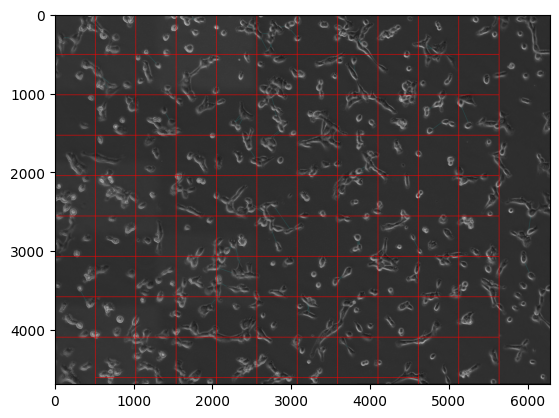

In [6]:
# Image with window segments superimposed 

plt.imshow(tmp);

In [7]:
len(img_array)

108

In [8]:
# Locating a sample image segment 

pixel_loc[36]

(2048, 0)

The image is sgemented columnwise. The pixel location (2048, 0) corresponds to the first row and fourth column image as shown below with the label marker. 

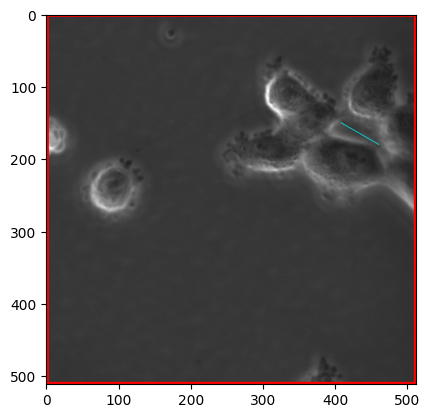

In [9]:
plt.imshow(img_label_array[36]);

The color of the label marker is yellow but in the above plot it looks different. This is because cv2 reads the colors as BGR. Below the images are convered from BGR to HSV and the mask for image is created

In [10]:
#convert all image segments to hsv color space

hsv_img = []
for i in range(len(img_label_array)):
    hsv_img.append(cv2.cvtColor(img_label_array[i], cv2.COLOR_BGR2HSV))

In [11]:
# lower bound and upper bound for Yellow color

lower_bound = np.array([20, 80, 80])
upper_bound = np.array([30, 255, 255])

In [12]:
mask = []
for i in range(len(hsv_img)):
    mask.append(cv2.inRange(hsv_img[i], lower_bound, upper_bound))

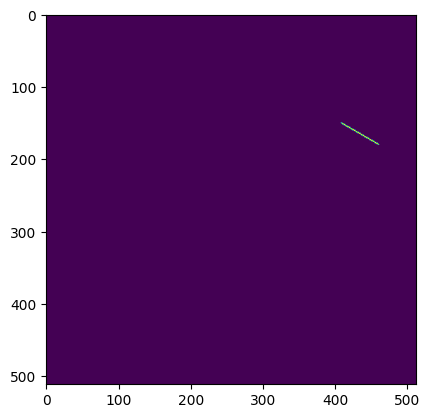

In [13]:
# Plotting the mask for the sample image with label

plt.imshow(mask[36]);

In [14]:
# Counting the number of pixels with the marker for each image segment

count = []
for i in range(len(mask)):
    count.append(np.count_nonzero(mask[i]))

In [15]:
# Creating a dataframe with array of segmented images, pixel location of each image and the count of label pixels 

dict_data = {"image" : img_array, "pixel_loc" : pixel_loc, "count" : count}
df_data = pd.DataFrame(dict_data)

In [16]:
# Initiating a 'target' varaible with '0' except when the label count of pixels is more than 100 

df_data['target'] = 0
df_data.loc[df_data['count'] > 100, 'target'] = 1

In [17]:
df_data.head()

,image,pixel_loc,count,target
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(0, 0)",108,1
1,"[[[0, 0, 0], [49, 49, 49], [50, 50, 50], [49, ...","(0, 512)",0,0
2,"[[[47, 47, 47], [47, 47, 47], [47, 47, 47], [4...","(0, 1024)",0,0
3,"[[[46, 46, 46], [47, 47, 47], [46, 46, 46], [4...","(0, 1536)",0,0
4,"[[[0, 0, 0], [0, 0, 0], [52, 52, 52], [53, 53,...","(0, 2048)",0,0


<AxesSubplot: >

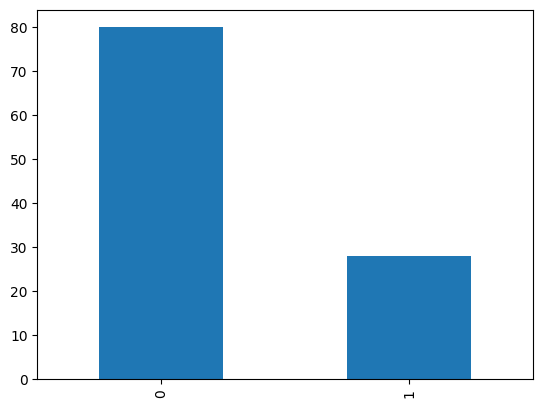

In [18]:
df_data.target.value_counts().plot.bar()

In [24]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [20]:
FAST_RUN = True #False
IMAGE_WIDTH=512
IMAGE_HEIGHT=512
IMAGE_SIZE1=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
IMAGE_SIZE = [224, 224]

In [21]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.summary()

2023-02-22 10:21:09.592016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
for layer in vgg.layers:
  layer.trainable = False

In [63]:
x = vgg.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='softmax')(x) # Softmax for multiclass
model = Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [64]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [27]:
from PIL import Image

In [28]:
df_model = df_data[['image', 'target']]

In [35]:
mypath = Path(os.path.abspath(""))

In [29]:
filenames = []
target = []
for i in range(len(df_model)) :
    im = Image.fromarray(df_model.loc[i][0])
    im.save("image" + str(df_model.loc[i][1]) + "_" + str(i) + ".jpeg")
    filenames.append("image" + str(df_model.loc[i][1]) +".jpeg")
    target.append(str(df_model.loc[i][1]))

In [31]:
def split_data(input_dir, output_dir, x):
    splitfolders.ratio(input_dir, output = output_dir, seed = 1337, ratio = (x,(1-x)/2, (1-x)/2), group_prefix = None)

In [38]:
split_data(mypath /'512_finetune', mypath/'512_finetune'/'data_split',0.8)

In [39]:
train_path=mypath / "512_finetune/data_split/train"

In [41]:
# Creating a dataframe with image paths and lables as columns

tar0_dir = train_path / '0'
tar1_dir = train_path /'1'

tar0_img = tar0_dir.glob('*.jpeg')
tar1_img = tar1_dir.glob('*.jpeg')

train_data = []
train_label = []

for img in tar0_img:
    train_data.append(str(img))
    train_label.append('0')
for img in tar1_img:
    train_data.append(str(img))
    train_label.append('1')
    
df_train = pd.DataFrame(train_data)
df_train.columns=['images']
df_train['labels'] = train_label

df_train = df_train.sample(frac=1).reset_index(drop=True)

In [40]:
train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
)

In [42]:
training_set = train_datagen.flow_from_dataframe(df_train,
                                                 '/Users/priyadas/Magnimind_mentorship/Proj2_deep_learn/512_finetune/data_split/train/',
                                                 x_col='images',
                                                 y_col = 'labels',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 86 validated image filenames belonging to 2 classes.


In [43]:
val_path=mypath / "512_finetune/data_split/val"

In [44]:
# Creating a dataframe with image paths and lables as columns

tar0_val = val_path / '0'
tar1_val = val_path /'1'

val_tar0_img = tar0_val.glob('*.jpeg')
val_tar1_img = tar1_val.glob('*.jpeg')

val_data = []
val_label = []

for img in val_tar0_img:
    val_data.append(str(img))
    val_label.append('0')
for img in val_tar1_img:
    val_data.append(str(img))
    val_label.append('1')
    
df_val = pd.DataFrame(val_data)
df_val.columns=['images']
df_val['labels'] = val_label

df_val = df_val.sample(frac=1).reset_index(drop=True)

In [45]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
        df_val,
        '/Users/priyadas/Magnimind_mentorship/Proj2_deep_learn/512_finetune/data_split/val/',
        x_col = 'images',
        y_col = 'labels',
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 16

)

Found 9 validated image filenames belonging to 2 classes.


In [46]:
FAST_RUN = True 

total_train = df_train.shape[0]
total_validate = df_val.shape[0]
batch_size=16

In [47]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [65]:
epochs=30 if FAST_RUN else 50
history = model.fit(
    training_set,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
5/5 [==============================] - 15s 3s/step - loss: 1.1261 - accuracy: 0.2571 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 16s 3s/step - loss: 1.5442 - accuracy: 0.2571 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 1.6662 - accuracy: 0.2429WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 16s 3s/step - loss: 1.6662 - accuracy: 0.2429 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 17s 3s/step - loss: 1.3660 - accuracy: 0.2714 - lr: 5.0000e-04
Epoch 5/30
5/5 [==============================] - 17s 3s/step - loss: 1.4519 - accuracy: 0.2857 - lr: 5.0000e-04
Epoch 6/30
5/5 [==============================] - 19s 4s/step - loss: 1.0216 - accuracy: 0.2500 - lr: 5.0000e-04
Epoch 7/30
5/5 [==============================] -

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    #df_test, 
    "/users/priyadas/Magnimind_mentorship/Proj2_deep_learn/test", 
    #x_col='filename',
    #y_col=None,
    class_mode='binary',
    target_size=(224, 224),
    batch_size=batch_size,
    #shuffle=False
)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    #df_test, 
    "/users/priyadas/Magnimind_mentorship/Proj2_deep_learn/test", 
    #x_col='filename',
    #y_col=None,
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    #shuffle=False
)

In [66]:
model.save_weights('model.h5')

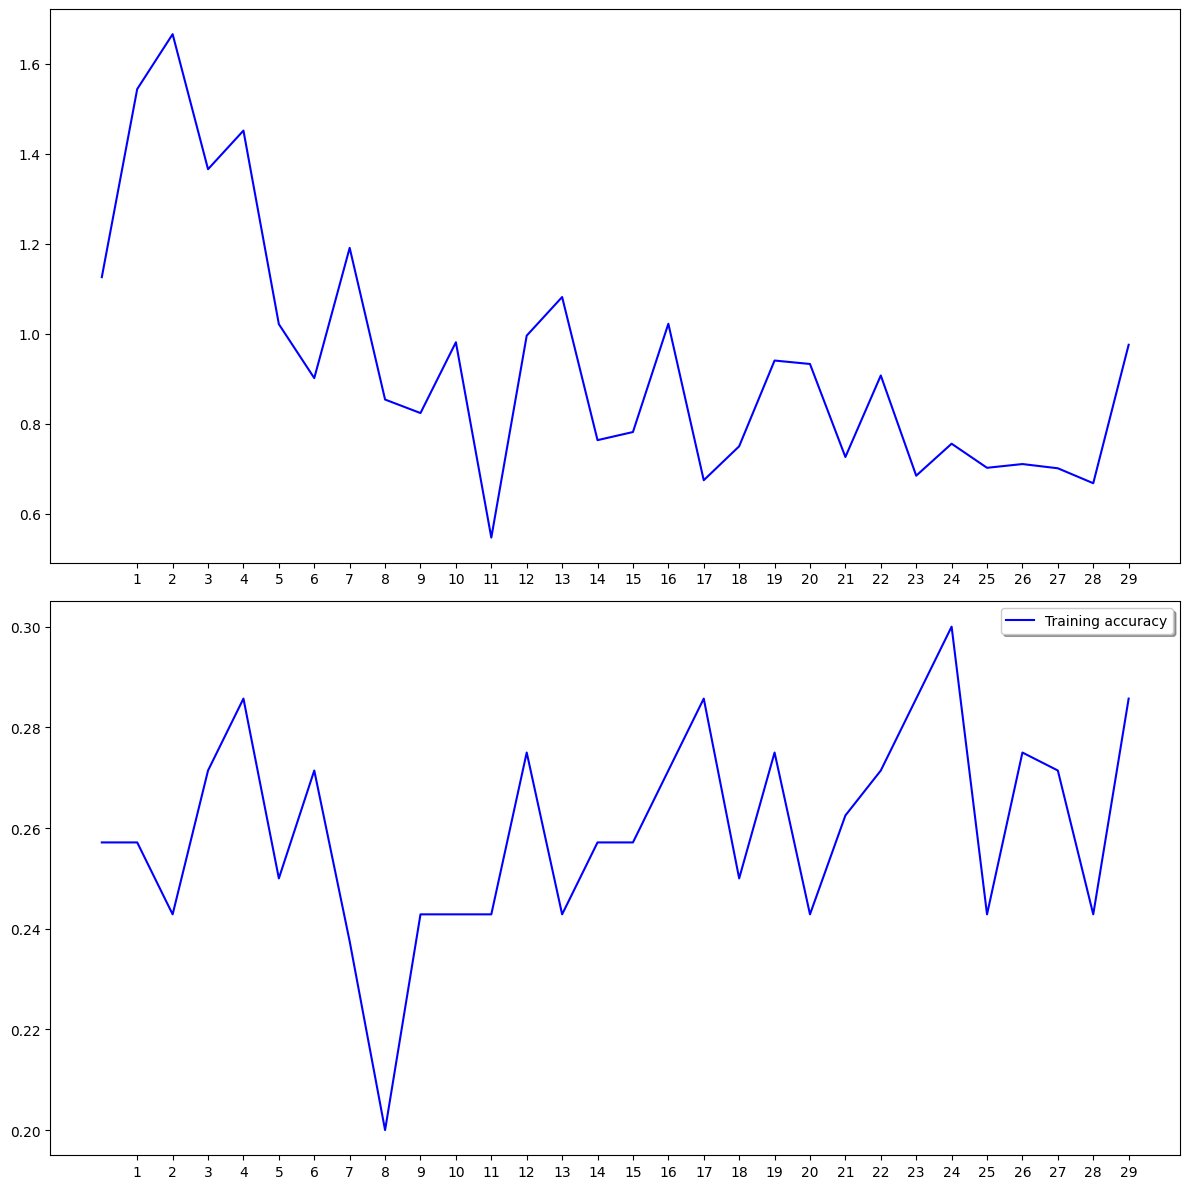

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
#ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
#ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
#ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
nb_samples = df_test.shape[0]

In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
df_test['predict'] = np.argmax(predict, axis=-1)

In [ ]:
nb_samples/batch_size

In [ ]:
df_test